In [64]:
# import modules
%matplotlib inline

import os
import random
import pylab
import pandas as pd
import numpy as np
import cPickle as pkl
from lasagne import layers, updates
from scipy.misc import imread, imresize
from lasagne.nonlinearities import softmax
from nolearn.lasagne import NeuralNet, BatchIterator
from sklearn.feature_extraction.image import extract_patches

data_root = '/home/faizy/workspace/project/project/datasets/'
model_root = '/home/faizy/workspace/project/project/models/'

icdar_root = 'icdar15/'
test_root = 'Challenge2_Test_Task3_Images'

test_size = 1095

In [4]:
# load models
f = open(model_root + 'detector_2.pkl', 'rb')
detector = pkl.load(f)
f.close()

f = open(model_root + 'recognizer.pkl', 'rb')
recognizer = pkl.load(f)
f.close()

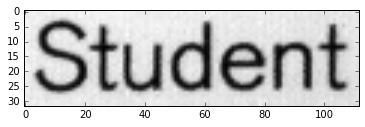

In [353]:
# visualize dataset
i = random.randrange(1, test_size)
img = imread(os.path.join(data_root, icdar_root, test_root, ('word_' + str(i) + '.png')), flatten = True)
pylab.imshow(img)
pylab.gray()
pylab.show()

image_height = img.shape[0]
image_width = img.shape[1]

In [354]:
print 'height: ', image_height, ',width: ', image_width

height:  32 ,width:  112


In [355]:
patches = extract_patches(img, (image_height, image_height*0.6))
print patches.shape

(1, 93, 32, 19)


In [356]:
new_lst = []
for i in range(patches.shape[0]):
    for j in range(patches.shape[1]):
        new_lst.append(imresize(patches[i, j, :, :], (32, 32)))
        
print len(new_lst)

93


In [357]:
new_list = np.stack(new_lst)
tester = new_list.reshape(patches.shape[0]*patches.shape[1], 1, 32, 32).astype('float32')
tester.shape

(93, 1, 32, 32)

In [358]:
tester /= tester.std(axis = None)
tester -= tester.mean()
tester = tester.astype('float32')

In [359]:
print tester.shape

(93, 1, 32, 32)


In [360]:
preder = detector.predict_proba(tester)

In [361]:
heatmap = preder[:, 1].reshape((patches.shape[0], patches.shape[1]))
print heatmap.shape

(1, 93)


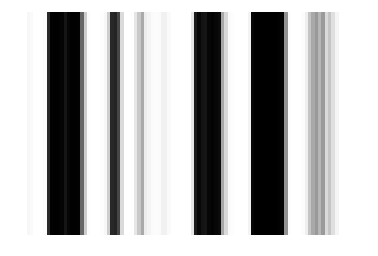

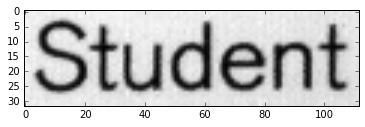

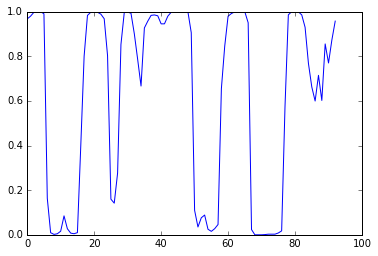

In [362]:
pylab.pcolor(heatmap[::-1])
pylab.axis('off')
pylab.show()
pylab.imshow(img)
pylab.show()
a = np.reshape(heatmap, patches.shape[1]*patches.shape[0])
pylab.plot(a)

In [363]:
from scipy.ndimage.filters import maximum_filter
peakind = np.nonzero(maximum_filter (a, size=(patches.shape[1]/5)*0.75) == a)[0]
breakind = np.nonzero(maximum_filter((1 - a), size=(patches.shape[1]/5)*4) == (1 - a))[0]
print peakind, breakind

[ 4 20 30 46 63 80 92] [ 8 69]


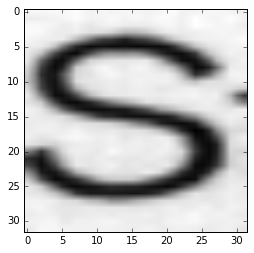

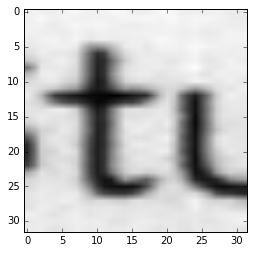

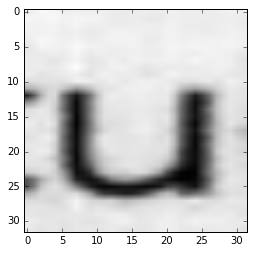

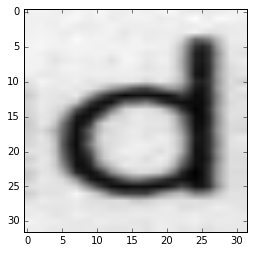

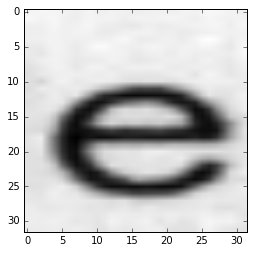

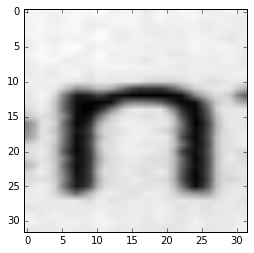

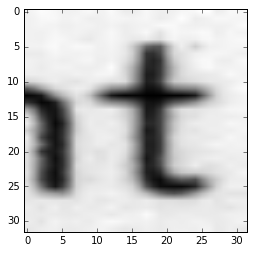

In [364]:
for i in peakind:
    pylab.imshow(tester[i, 0, :, :])
    pylab.gray()
    pylab.show()

In [365]:
word = np.zeros((len(peakind), 1, 32, 32))
for idx, item in enumerate(peakind):
    word[idx, ...] = tester[item, 0, :, :]
    
word = word.astype('float32')

In [366]:
predict = recognizer.predict(word)

In [367]:
# Define word recognition functions
import re, collections

def words(text): return re.findall('[a-z]+', text.lower()) 

def train(features):
    model = collections.defaultdict(lambda: 1)
    for f in features:
        model[f] += 1
    return model

NWORDS = train(words(file(data_root + 'big.txt').read()))

alphabet = 'abcdefghijklmnopqrstuvwxyz'

def edits1(word):
   splits     = [(word[:i], word[i:]) for i in range(len(word) + 1)]
   deletes    = [a + b[1:] for a, b in splits if b]
   transposes = [a + b[1] + b[0] + b[2:] for a, b in splits if len(b)>1]
   replaces   = [a + c + b[1:] for a, b in splits for c in alphabet if b]
   inserts    = [a + c + b     for a, b in splits for c in alphabet]
   return set(deletes + transposes + replaces + inserts)

def known_edits2(word):
    return set(e2 for e1 in edits1(word) for e2 in edits1(e1) if e2 in NWORDS)

def known(words): return set(w for w in words if w in NWORDS)

def correct(word):
    candidates = known([word]) or known(edits1(word)) or known_edits2(word) or [word]
    return sorted(candidates,  key=NWORDS.get, reverse = True)

def classer(arrayer):
    classer_array = []
    for i in range(len(arrayer)):
        if (0 <= arrayer[i] < 10):
            classer_array.append(arrayer[i])
        elif (10 <= arrayer[i] < 36) :
            classer_array.append(alphabet[arrayer[i] - 10].upper())
        elif (36 <= arrayer[i] < 62):
            classer_array.append(alphabet[arrayer[i] - 36])
        else : 
            print 'Is the array correct!?'
    return classer_array

In [368]:
real_pred = classer(predict)
real_pred = map(str, real_pred)
letter_stream = ''.join(real_pred).lower()

In [369]:
print letter_stream

student


In [370]:
print 'Probable words are: ', ', '.join(correct(letter_stream))

Probable words are:  student


In [233]:
a1 = [0,16,33,46]
a2 = [22,54]
for idx, i in enumerate(a2):
  a3 = []
  for idxj, j in enumerate(a1):
   if j < i:
    a3.append(j)
    a1.pop(idxj);
    print a1, a2, a3
   else:
     print a3[0]
     break
    
  print 'dx', i

[16, 33, 46] [22, 54] [0]
0
dx 22
[33, 46] [22, 54] [16]
[33] [22, 54] [16, 46]
dx 54


In [234]:
a3.append(3)

In [235]:
a3

[16, 46, 3]

In [242]:
a1 = [0,16,33,46]
a2 = [22,54]
a2.insert(0, 0)
for i in range(len(a2) - 1):
    print range(a2[i], a2[i+1])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]
[22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53]


In [250]:
a1 = np.array([0, 16, 33, 46])
a2 = np.array([22, 54])

for i in a2:
    print a1 < i

[ True  True False False]
[ True  True  True  True]
